<div style="background-color:#ff6666;
font-weight:bold;
font-size:5.2rem;
display:block;
width:80%;
padding:1.2em;
align:center;">

Module 3 Project

# Introduction


### Goals:

Cardiovascular diseases (CVDs) are the leading cause of death worldwide, claiming around 17 million lives per year. Our goals for this project will be producing the best model(s) that identify and define both the protective and risk factors when it comes to predicting the prevalence of a CVD. Through the knowledge of these factors, we would be able to target the best primary prevention methods and help deter possible development of some CVDs.

**Questions:**

1. What are the top performing "vanilla" models for this type of dataset in terms of accuracy?
2. What are the most significant factors when it comes to classifying those with and without a CVD?
3. What are the most significant risk and protective factors when it comes to predicting if an observation has a CVD?

# Methodology


In this project we are going to be using the **OSEMN** Process:

1. **Obtain**: Since we found our dataset on Kaggle, we just need to load it into the Jupyter Notebooks.


(**Inspecting, Scrubbing, and Exploring** are all meshed together in this process)
2. **Inspecting & Scrubbing**: This is where we inspect clean the data (where we absolutely have to). In this section, we will be looking for: outliers, null values, making sure the values within certain columns are reasonable, and viewing the types of values within each column.

3. **Explore**: Looking at our data and the relationship between the features and our target, and identifying any missed outliers.

4. **Modeling**: We will then create multiple types of classification models to determine which factors play a significant role when classifying the likelihood of having a Cardiovascular Disease.

5. **Interpretion**: Results and Conclusion of models.

# Obtaining Our Dataset

Importing the necessary libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import sklearn
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report as cls_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (precision_recall_curve, plot_confusion_matrix, 
                             plot_roc_curve, recall_score)
import xgboost as xgb
import time
import shap
import pickle
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

Our dataset needs a semicolon separator to load in correctly. Also, we will be using the 'id' column as our dataset's index.

In [5]:
df_raw = pd.read_csv('cvd.csv', sep=';', index_col='id')

# Exploring & Scrubbing

In this section, we will be:

- taking a look at the types of values within each column.
- looking for and removing/replacing any null/NaN values.
- creating new columns to use for our models.
- looking at the relationship between some of our features and comparing them to our target feature.

In [6]:
df_raw.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
age            70000 non-null int64
gender         70000 non-null int64
height         70000 non-null int64
weight         70000 non-null float64
ap_hi          70000 non-null int64
ap_lo          70000 non-null int64
cholesterol    70000 non-null int64
gluc           70000 non-null int64
smoke          70000 non-null int64
alco           70000 non-null int64
active         70000 non-null int64
cardio         70000 non-null int64
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


We have all integer and float columns in this dataset. About half of them seem to be binary or ordinal.

**Types of Features Within Our Dataset**

**Objective** Features:
(Factual Information)
- Age | Objective Feature | **age** | int (days) |
- Height | Objective Feature | **height** | int (cm) |
- Weight | Objective Feature | **weight** | float (kg) |
- Gender | Objective Feature | **gender** | categorical code |

**Examination** Features:
(Results of Medical Examination)
- Systolic blood pressure | Examination Feature | **ap_hi** --> changed to **systolic** | int |
- Diastolic blood pressure | Examination Feature | **ap_lo** --> changed to **diastolic** | int |
- Cholesterol | Examination Feature | **cholesterol** | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | **gluc** | 1: normal, 2: above normal, 3: well above normal |

**Subjective** Features:
(Information given by the Patient)
- Smoking | Subjective Feature | **smoke** | binary |
- Alcohol intake | Subjective Feature | **alco** | binary |
- Physical activity | Subjective Feature | **active** | binary |

**Target Feature**:

- Presence or absence of cardiovascular disease | Target Variable | **cardio** --> changed to **cvd** | binary |


In [8]:
for col in df_raw.columns:
    print(f"{col}: {df_raw[col].nunique()}")

age: 8076
gender: 2
height: 109
weight: 287
ap_hi: 153
ap_lo: 157
cholesterol: 3
gluc: 3
smoke: 2
alco: 2
active: 2
cardio: 2


**Numerical Columns**:
- age
- height
- weight
- ap_hi
- ap_lo

**Categorical Columns (Ordinal)**:
- gluc
- cholesterol

**Categorical Columns (Binary)**:
- gender
- smoke
- alco
- active
- cardio



#### Renaming columns

We are going to rename some of the columns within the dataset just to make them easier to interpret and use to create new columns later on down the road.

- ap_hi --> systolic
- ap_lo --> diastolic
- cardio --> cvd

#### Dropping duplicate rows

Our next step in this process is to find and remove any duplicate rows found in the dataset. In our raw dataset we found approximately 24 rows that were duplicates, and removed them from our dataset.

Loading in our cleaned dataframe from our notebook:

In [9]:
# Loading our df_clean
with open('df_clean.pickle', 'rb') as f:
    df_clean = pickle.load(f)

#### Modifying the 'age' column

Since 'age' in the dataset is based off of the number of days, that makes it harder for us to determine the age range in our dataset. Instead of keeping it that way, we are going to be converting age from days into years.

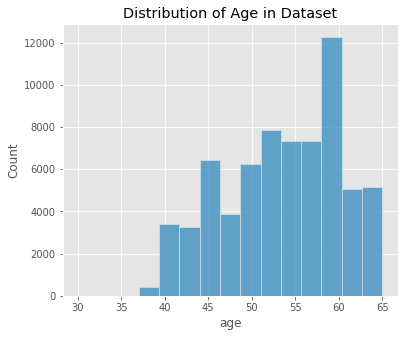

In [10]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.histplot(data=df_clean, x='age', bins=15)
ax.set_title('Distribution of Age in Dataset');

Our age range in this dataset contains patients from 30 - 65 years of age.

#### Modifying the 'gender' column

We are going to change the values of gender from (1, 2) to (0, 1) so our models can work with the binary numbers in that column.

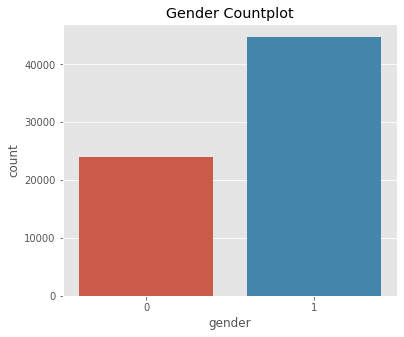

In [11]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.countplot(data=df_clean, x='gender')
ax.set_title('Gender Countplot');

In [12]:
df_clean['gender'].value_counts(normalize=True).round(4)

1    0.6513
0    0.3487
Name: gender, dtype: float64

## Creating New Columns

#### BMI column

Formula: $weight (kg) / (height[cm]/100)^2$

According to the CDC, "Body mass index (BMI) is a person’s weight in kilograms divided by the square of height in meters. BMI is an inexpensive and easy screening method for weight category—underweight, healthy weight, overweight, and obesity."(Centers for Disease Control and Prevention)

The formula for **BMI** is weight in kilograms divided by height in meters squared. If height has been measured in centimeters, divide by 100 to convert this to meters.

Since we have the 'height' and 'weight' columns in our dataset, we can use these features to create a 'bmi' column for each observation in our dataset. Creating this column could further help classify those with and without a cardiovascular disease.

#### Pulse Pressure column

According to Yildiran, Tansel et al., "**Pulse pressure**(PP) is the difference between systolic and diastolic blood pressure (BP) values. Pulse pressure markedly rises after the 5th decade of life, due to arterial stiffening with increasing age. Several studies have shown a close relationship between high PP and the occurrence of cardiovascular (CV) death. Furthermore, high PP is a risk factor for the development of coronary heart disease, myocardial infarction, and heart failure in normotensive and hypertensive persons."(Yildiran, Tansel et al., 2010) 

Just like 'bmi', creating a 'pulse_pressure' column could help with classifying those with and without a cardiovascular disease.

#### Blood Pressure Categories column

We create this column to categorize blood pressure into the five blood pressure ranges recognized by the American Heart Association. These five categories are: Normal, Elevated, Hypertension I, Hypertension II, & Hypertension III. (American Heart Association)

In [13]:
# Creating a categorical column to determine Blood Pressure Categories
# These values are from the American Heart Association. (Must cite this)
def bp_cat(row):
    """
    Definition:
    applies a categorical value based on a row's systolic and diastolic levels.
    These values are recognized by the American Heart Association.
    
    Args:
    row: row in the dataframe
    
    Returns:
    The Categorical value for each row.
    """
    
    if (row['systolic'] < 120) and (row['diastolic'] < 80):
        return 'normal'
    elif ((row['systolic'] >= 120) and (row['systolic'] < 130)) and (row['diastolic'] < 80):
        return 'elevated'
    elif ((row['systolic'] >= 130) and (row['systolic'] < 140)) or ((row['diastolic'] >= 80) and (row['diastolic'] < 90)):
        return 'hypertension_1'
    elif ((row['systolic'] >= 140) and row['systolic'] < 180) or ((row['diastolic'] >= 90) and row['diastolic'] < 120):
        return 'hypertension_2'
    else:
        return 'hypertension_3'
        

In [14]:
df_clean['bp_cat'].value_counts()

hypertension_1    39750
hypertension_2    16096
normal             9569
elevated           3122
hypertension_3      149
Name: bp_cat, dtype: int64

In [15]:
def frequency_plot(df, group, target, order=None, title='', xlabel='', get_df=0, 
                  figsize=(7,6)):
    """
    Definition plots the percentage of no CVD to CVD in each value of a column
    
    Args:
    df = dataframe
    group = column to look at
    target = target value (CVD). Used to define the hue of the plot
    order = a list of values defined within the column
    title = the plot's title
    xlabel = the plot's xlabel
    get_df = returns df_plot if get_df=1. Default is set to 0.
    
    Returns:
    df_plot if get_df == 1.
    Plots the frequency plot using seaborn's barplot on our grouped dataframe
    """
    
    df_plot = df.groupby(group)[target].value_counts(normalize=True).\
              to_frame('frequency').reset_index()
    fig, ax = plt.subplots(figsize=(figsize))
    ax = sns.barplot(data=df_plot, x=group, y='frequency', hue=target, 
                    order=order)
    ax.set_title(title)
    if len(xlabel) > 0:
        ax.set_xlabel(xlabel)
    plt.show()
    
    if get_df:
        return df_plot

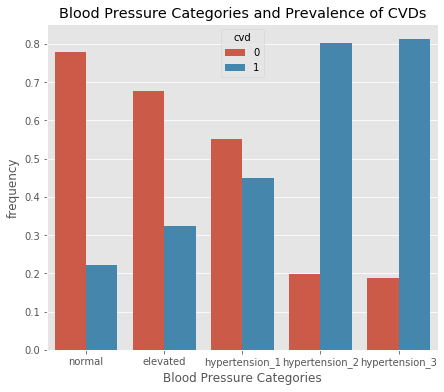

In [16]:
order = ['normal', 'elevated', 
               'hypertension_1', 'hypertension_2', 'hypertension_3']

frequency_plot(df_clean, group='bp_cat', target='cvd', order=order, 
               title='Blood Pressure Categories and Prevalence of CVDs',
              xlabel='Blood Pressure Categories')

According to our plot, those who have hypertension 2 or greater are much more likely to have a CVD. Those with a normal blood pressure seem to be less likely to have a CVD. Those with hypertension 1 have a greater chance of having a CVD than those with a normal blood pressure. 

#### BMI Categories column

According to the Centers for Disease Control and Prevention, "for adults 20 years old and older, BMI is interpreted using standard weight status categories. These categories are the same for men and women of all body types and ages." (Centers for Disease Control and Prevention)

The four categories recognized by the CDC are:
- underweight
- normal
- overweight
- obese

In [17]:
def bmi_cat(row):
    """
    Definition:
    Applies a categorical value for each row in the dataframe based on the value
    of the bmi for that row. These values are recognized by the Centers for Disease
    Control and Prevention.
    
    Args:
    row = row in dataframe
    
    Returns:
    Categorical value for each row in the dataframe.
    """
    
    if (row['bmi'] < 18.5):
        return 'underweight'
    elif (row['bmi'] >= 18.5) and (row['bmi'] < 25):
        return 'normal'
    elif (row['bmi'] >= 25) and (row['bmi'] < 30):
        return 'overweight'
    else:
        return 'obese'
        

In [18]:
df_clean['bmi_cat'].value_counts()

normal         25294
overweight     24717
obese          18038
underweight      637
Name: bmi_cat, dtype: int64

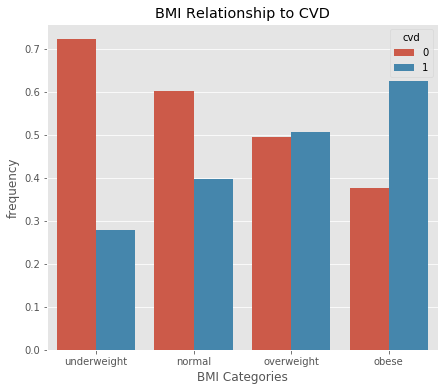

In [19]:
order = ['underweight', 'normal', 'overweight', 'obese']

frequency_plot(df_clean, group='bmi_cat', target='cvd', order=order, 
              title='BMI Relationship to CVD', xlabel='BMI Categories')

According to this graph, if a person is overweight or obese, they are more likely to have a CVD than a person who has a normal BMI.

## Inspecting and Exploring Other Columns

#### Looking at 'gluc' column

Within the 'gluc' column, there are three values:

* 1 = normal levels of glucose
* 2 = above normal levels of glucose
* 3 = very above normal levels of glucose

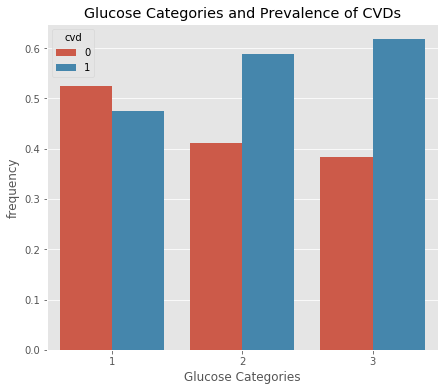

In [20]:
frequency_plot(df_clean, group='gluc', target='cvd', 
               title='Glucose Categories and Prevalence of CVDs',
              xlabel='Glucose Categories')

It seems that if a person has an above normal or very above normal glucose level (2 or 3), they may be more at risk of having a CVD when compared to a person who has a normal glucose level (1).

In [21]:
df_clean['gluc'].value_counts()

1    58400
3     5217
2     5069
Name: gluc, dtype: int64

#### Looking at 'cholesterol' column

Within the 'cholesterol' column, there are three values:

* 1 = normal levels of cholesterol
* 2 = above normal levels of cholesterol
* 3 = very above normal levels of cholesterol

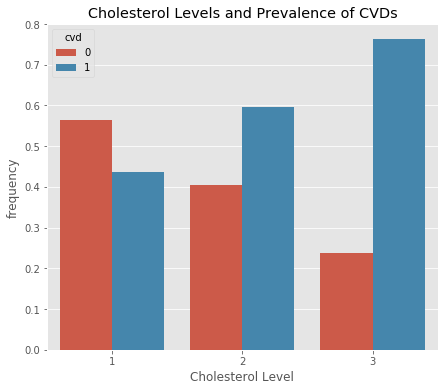

In [22]:
frequency_plot(df_clean, group='cholesterol', target='cvd', 
               title='Cholesterol Levels and Prevalence of CVDs',
              xlabel='Cholesterol Level')

It seems there is definitely a relationship between the prevalence of having a cardiovascular disease and higher than normal cholesterol levels.

In [23]:
df_clean['cholesterol'].value_counts()

1    51506
2     9305
3     7875
Name: cholesterol, dtype: int64

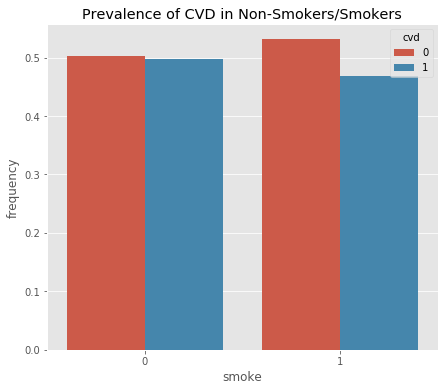

In [24]:
frequency_plot(df_clean, 'smoke', 'cvd', title='Prevalence of CVD in Non-Smokers/Smokers')

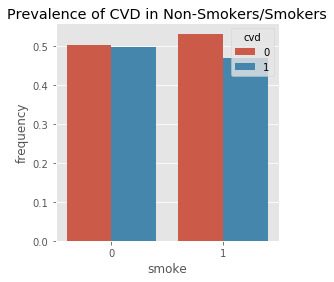

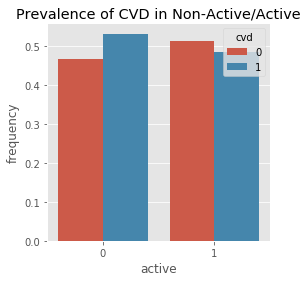

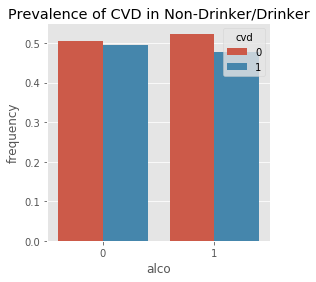

In [25]:
frequency_plot(df_clean, 'smoke', 'cvd', 
               title='Prevalence of CVD in Non-Smokers/Smokers', figsize=(4, 4))

frequency_plot(df_clean, 'active', 'cvd', 
               title='Prevalence of CVD in Non-Active/Active', figsize=(4, 4))


frequency_plot(df_clean, 'alco', 'cvd', 
               title='Prevalence of CVD in Non-Drinker/Drinker', figsize=(4, 4))

According to these graphs, it seems that there is little to no relationship between CVD and smoking or drinking.

There may be slight correlation between 'active' and the presence of a CVD.

These columns are subjective and also are only boolean values. For example, someone who drinks multiple glasses every night versus someone who drinks 2-3 glasses a week are still classified as a drinker, yet their risk of a CVD may be different. 

#### Binning Age into Decades

Here we create a new column called 'age_by_decade' that classifies what decade an observation is in. We create four different categories than encompass the range of our dataset:

- 30s = age from 30 to 39
- 40s = age from 40 to 49
- 50s = age from 50 to 59
- 60s = age from 60 to 69

In [26]:
df_clean['age_by_decade'] = pd.cut(x=df_clean['age'], 
                                   bins=[30, 39, 49, 59, 69], 
                                   labels=['30s', '40s', '50s', '60s'], 
                                  include_lowest=True)

In [27]:
df_clean.head(3)

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,pulse_pressure,bp_cat,bmi_cat,age_by_decade
id,,,,,,,,,,,,,,,,,
0,50,0,168,62.0,110,80,1,1,0,0,1,0,21.97,30,hypertension_1,normal,50s
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.93,50,hypertension_2,obese,50s
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.51,60,hypertension_1,normal,50s


In [28]:
df_clean['age_by_decade'].value_counts()

50s    34664
40s    18036
60s    15581
30s      405
Name: age_by_decade, dtype: int64

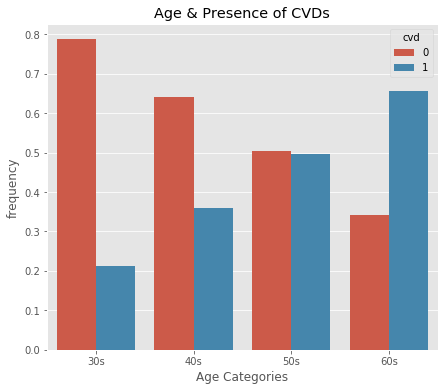

In [29]:
order = ['30s', '40s', '50s', '60s']

frequency_plot(df_clean, 'age_by_decade', 'cvd', order=order, 
              title='Age & Presence of CVDs', xlabel='Age Categories')

From this plot, it looks like as age increases, so does the likelihood of having a Cardiovascular Disease.

#### Looking at a basic correlation between our target variable and our numerical features

In [30]:
df_importance = pd.DataFrame(df_clean.corr()['cvd']).\
                sort_values(by='cvd',ascending=False)

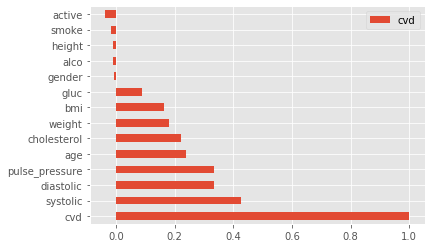

In [31]:
df_importance.plot(kind='barh');

Based on this correlation plot we see that systolic, diastolic, pulse_pressure, age, cholesterol, weight, bmi, and gluc are all significant factors when predicting if someone may have a CVD.
Active may be slightly significant in helping prevent the chance of developing a CVD.

Smoke, height, alco, and gender don't seem to carry much weight in terms of significance.

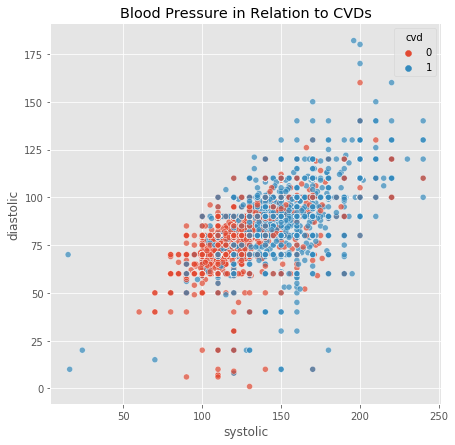

In [77]:
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x='systolic', y='diastolic', hue='cvd', data=df_clean, alpha=0.7)
plt.title('Blood Pressure in Relation to CVDs');

## Inspecting Outliers

#### We find some major outliers present in columns: 
- height
- weight
- systolic
- diastolic

(bmi and pulse_pressure also have outliers, but we made those columns using the above columns)

#### Setting filters on 'systolic' and 'diastolic' columns

We are going to be setting filters on our dataset for systolic and diastolic. According to Narloch and Brandstater, the highest Blood Pressure ever recorded was 370/360. This was also during an intense excerise. This is an extremely high blood pressure, and can be considered an excessively safe limitation for our dataset. (Narloch & Brandstater, 1995)

Other filters for systolic and diastolic pressure:
- systolic and diastolic pressures cannot be negative
- systolic pressure will always be greater in value than diastolic pressure, therefore we cannot have a negative pulse pressure

In [32]:
df_clean = df_clean[(df_clean['systolic'] >= 1) & (df_clean['systolic'] <= 370)]

In [33]:
df_clean = df_clean[(df_clean['diastolic'] >= 1) & (df_clean['diastolic'] <= 360)]

In [34]:
df_clean = df_clean[df_clean['pulse_pressure'] > 0]

## Viewing Difference of Columns When Comparing CVD

Here we are looking at each individual column and using 'cvd' as our hue to see if there are any that look practically identical. If they do, we can safely assume that we can drop that column because it does not provide insight when classifying for CVDs.

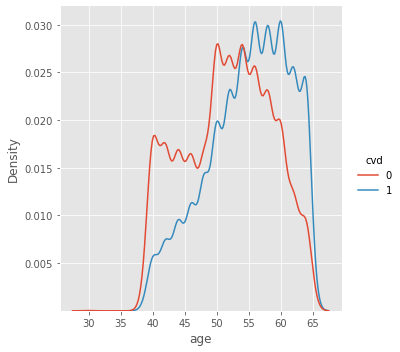

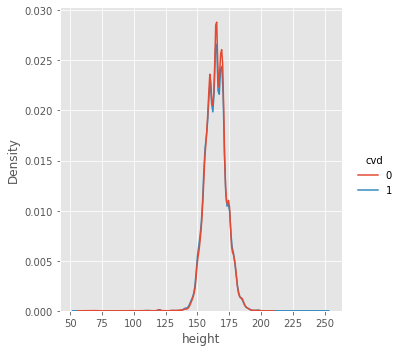

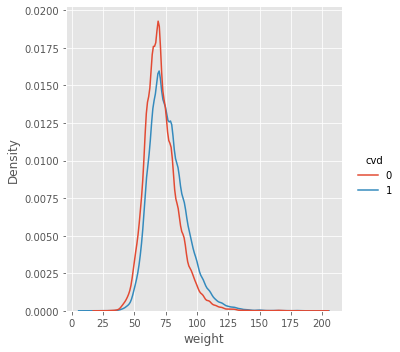

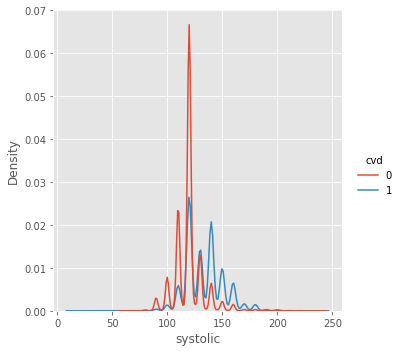

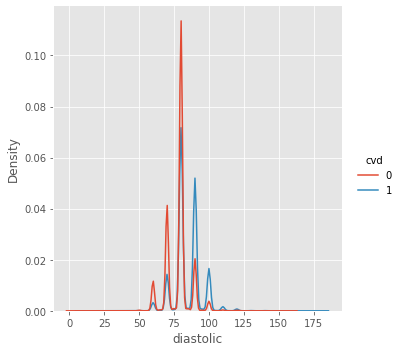

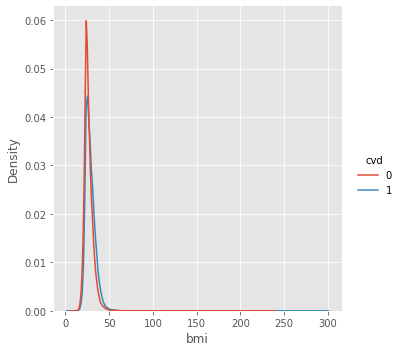

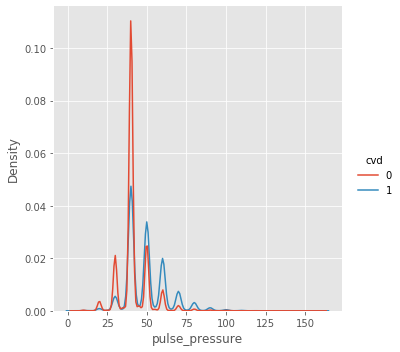

In [36]:
# Using the cut_df to better inspect the difference w/o interference of outliers
for item in ['age', 'height', 'weight', 'systolic', 'diastolic', 'bmi', 
              'pulse_pressure']:
    sns.displot(kind='kde', data=df_clean, x=item, hue="cvd")

We are inspecting each of the columns to see the relationship between the column and the Presence of a CVD. For height, there seems to be no major difference in the distribution for people with and without a CVD. Therefore, we can safely remove this column when working with our models.

## Train-Test Split

Here, we separate our dataframe into our features (X) and our target (y). We will make our test size about 20% of the data, and our training data will be the remaining 80%. We also set a random state.

In [37]:
# Standard - for pipelined models
X = df_clean.drop(['cvd', 'height'], axis=1) #Dropping height, not significant
y = df_clean['cvd']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                   random_state=42)

Here we see that the target values are already well balanced.

In [39]:
pd.Series(y_test).value_counts(normalize=True)

0    0.50757
1    0.49243
Name: cvd, dtype: float64

In [40]:
print(f"X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}")

X_train shape: (54948, 15)
X_test shape: (13738, 15)


# Modeling

#### Defining Functions

The evaluate_classification function allows us to iterate through our pipeline of models to find the best performing "vanilla" model out of the models we've selected to further fine tune.

In [41]:
def evaluate_classification(model,X_test,y_test,X_train, y_train, classes=None,
                           normalize='true',cmap='Reds',label='', 
                           preprocessed=0):
    
    """
    Definition:
    Accepts an sklearn-compatible classification model, train data, and test data 
    and displays several sklearn.metrics functions: 
    - classifciation_report
    - plot_confusion_matrix
    - plot_roc_curve
    - plots top 10 important features for each model (Not including KNN and SVM)
    
    Args:
    model: type of machine learning model you want to use
    X_test, y_test, X_train, y_train: self_explanatory
    classes: default = 'None'. Used in classification_report and 
    plot_confusion_matrix. 
    normalize: default = 'true'. Normalizes the values in the 
    plot_confusion_matrix function.
    cmap: default = 'Reds'. Specifies the palette used in plot_confusion_matrix
    label: default = ''. Used in the title for the Classification Report
    return_dict: default = 0. If 1, can return a dict containing the 
    classification_report values.
    preprocessed: default = 0. If 1, assumes the model has been preprocessed, and will attempt
    to graph out the model's feature importances.
    
    Returns:
    Plots a confusion matrix, ROC curve, feature importance graph, 
    and train and test scores
    Can also return a report dictionary (report_dict = 1).
    """
     
    ## Get Predictions
    y_hat_test = model.predict(X_test)
    
    
    ## Basic Header 
    table_header = "             [i] CLASSIFICATION REPORT"
    
    ## Add Label to Basic Header if given
    if len(label)>0:
        table_header += f" for {label.upper()}"
        
    
    ## Classification Report
    dashes = '---'*20
    print(dashes,dashes,table_header,dashes,sep='\n')

    print(cls_report(y_test,y_hat_test,
                                    target_names=classes))
    
    print(dashes, dashes, sep='\n')

    # displays the accuracy for train and test
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    print(f"Training data score: {train_score}\nTest data score: {test_score}")
    print(f"{dashes}\n")
    # Will print "overfitting" if model may be overfitting
    if train_score - test_score >= 0.05:
        print('Model may be Overfitting')

    ## PLotting figures
    fig, axes = plt.subplots(figsize=(10,4),ncols=2)
    
    ## Plot Confusion Matrix on first ax
    plot_confusion_matrix(model, X_test,y_test,
                                  display_labels=classes,
                                  normalize=normalize,
                                 cmap=cmap,ax=axes[0])
    axes[0].set(title='Confusion Matrix')
    
    ## Plot Roc Curve on second ax
    roc_plot = plot_roc_curve(model, X_test, y_test,ax=axes[1])
    axes[1].legend()
    # Threshold line
    axes[1].plot([0,1],[0,1],ls=':')
    axes[1].grid()
    axes[1].set_title('ROC Curve') 
    
    # If data is preprocessed and not a 'knn' 'or svm' Classifier, this will print
    # a list of top ten important features for the model.
    if preprocessed: 
        if (label != 'knn') & (label != 'svm'):

            categ_cols = model.named_steps['preprocesser'].named_transformers_['cat'].\
                            named_steps['encoder'].get_feature_names(cat_cols).tolist()

            feature_names = num_cols + categ_cols

            important_feats = pd.Series(model.named_steps[label].feature_importances_,
                                       index=feature_names)
            top_feats = important_feats.sort_values(ascending=False).head(10)
            plt.figure(figsize=(5, 5))
            top_feats.sort_values().plot(kind='barh')
            plt.title(f'Most Important Features for {label.upper()}')
            plt.xlabel('Level of Importance')
            plt.ylabel('Features');

    fig.tight_layout()
    plt.show()

The model_search function implements RandomizedSearch and GridSearch to fine tune our selected models and also uses the evaluate_classification function to display the performance.

In [42]:
def model_search(model, param_grid, X_train, y_train, X_test, 
                y_test, search='random', scoring='recall', classes=None,
                normalize='true',cmap='Reds',label='', return_dict=0, n_iter=50, 
                preprocessed=0, get_model=1, get_grid=0):
    """
    Definition:
    Allows you to specify what type of search you want to use on 
    your classification model (randomized or grid). Then takes the model, tunes 
    it based on the scoring parameter you apply, and puts it in the 
    evaluate_classification function.
        
    Args:
    model: type of machine learning model you want to use
    param_grid: parameter grid for search to use on the model
    X_train, y_train, X_test, y_test: self-explanatory
    search: default = 'random'. Can also be set to 'grid'
    scoring: default = 'recall'. Can be set to multiple other scoring types.
    classes: default = 'None'. Used in the classification_report and 
    plot_confusion matrix in evaluate_classification function.
    normalize: default = 'true'. Used in the plot_confusion_matrix in 
    evaluate_classification function.
    cmap: default = 'Reds'. Used in the plot_confusion_matrix in 
    evaluate_classification function.
    label: default = ''. Used in evaluate_classification function
    return_dict: default = 0. Used in evaluate_classification function
    n_iter: default = 50. Used if the type of search is 'random'
    
    Returns:
    plots a confusion matrix, ROC curve, train and test scores. Also shows the
    amount of time it took to run the function. Can also return a dict of the
    classification_report.
    """
    #Grid search template
    if search == 'grid':
        start = time.time()

        clf = GridSearchCV(model, param_grid=param_grid,scoring=scoring, cv=3)
        clf.fit(X_train, y_train)
        print(clf.best_params_)

        finish = time.time()
        print(f"Time to run program: {np.round((finish - start)/60, 2)} min")
        
    #Randomized Search Template
    else:
        start = time.time()

        clf = RandomizedSearchCV(model, param_distributions=param_grid, 
                                      n_iter=n_iter, scoring=scoring)
        clf.fit(X_train, y_train)
        print(clf.best_params_)

        finish = time.time()
        print(f"Time to run program: {np.round((finish - start)/60, 2)} min")
        
    
        
    eval_class = evaluate_classification(clf.best_estimator_, X_test, y_test,
                            X_train, y_train, classes=classes, normalize=normalize, 
                            cmap=cmap, label=label, preprocessed=preprocessed)

    if get_grid:
        if get_model:
            return clf, clf.best_estimator_
        else:
            return clf
    elif get_model:
        return clf.best_estimator_

### Baseline Model using DummyClassifier

We make a dummy classifier because it gives us a measure of the baseline performance, which is equivalent to the success rate if one were to just simply guess. The dummy classifier acts independently of the prediction features, it doesn't take those variables into account.

In [43]:
#Creating a DummyClassifier and targeting the non-majority label in CVD (1)
dummy = DummyClassifier()

In [44]:
# Fitting the Classifier to our training data and using predict to make sure we
# are targeting what we want to target
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

Recall Score: 0.4931263858093126
Accuracy: 0.4982530208181686


              precision    recall  f1-score   support

           0       0.50      0.50      0.50      6973
           1       0.49      0.49      0.49      6765

    accuracy                           0.50     13738
   macro avg       0.50      0.50      0.50     13738
weighted avg       0.50      0.50      0.50     13738

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT for DUMMY
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      6973
           1       0.50      0.50      0.50      6765

    accuracy                           0.51     13738
   macro avg       0.51      0.51      0.51     13738
weighted avg       0.51      0.51      0.51     13738

--------------------------------------------------

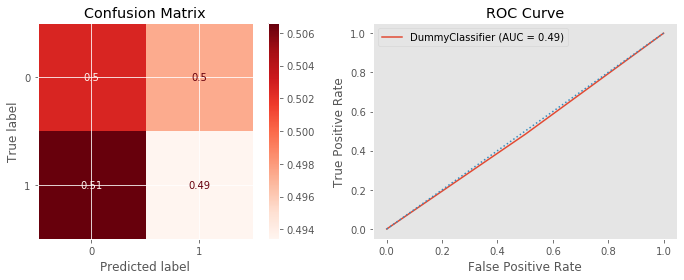

In [49]:
# Recall score of our baseline model
# print(f"Recall Score: {recall_score(y_test, y_pred)}")
# Classification report
print(f"Accuracy: {dummy.score(X_test, y_test)}\n\n")
print(cls_report(y_test, y_pred))

evaluate_classification(dummy, X_test, y_test, X_train, y_train, label='Dummy')

Our Baseline Model has an accuracy of around 50%, which is as good as flipping a coin. Since we are trying to classify the best risk and protective factors when determining who has a Cardiovascular Disease, we need to make a model that's has a better accuracy than this.

### Iterating through our Vanilla Pipelined Models

In this step we get a little complicated and create a pipeline to run five different type of 'vanilla' models through our evaluate_classification function. The goal is to find the best performing models to further fine tune them. The five vanilla models we are going to analyze are:

- KNearestNeighborsClassifier
- SVClassifier
- DecisionTree
- RandomForests
- XGBoostClassifier

**Numerical Transformers**

Within our pipeline, we must **define two different types of numerical transformers**. Both of these transformers will imputer any null values and replace with the median, however, the first transformer will also scale the values.

**numerical_transformer_1**:
- impute and replace with median
- scale using standardscaler

**numerical_transformer_2**:
- impute and replace with median

The reason for this is because of the types of models we are using. While DecisionTree, RandomForests, and XGBoost don't need to be scaled -- KNN and SVC both require numerical values to be scaled.

In [87]:
# Numerical Transformer
num_transformer_1 = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scale', StandardScaler())])

In [88]:
num_transformer_2 = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median'))])

**Categorical Transformer**

Our categorical transformer will be used for all our models, so we don't need to make a second one. The process for our categorical transformer will be:

- impute and replace any null values with 'missing'
- encode using OneHotEncoder, and setting the parameter handle_unknwon to ignore unknown values

In [89]:
# Categorical Transformer
cat_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', 
                                          fill_value='missing')),
                ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

**Preprocessors**

We then make lists of the numerical and categorical column names.

We will have two types of preprocessors, one for the scale-required models, and the other for the tree models. Both are ColumnTransformers that will take in one numerical transformer and the categorical transformer.

**Preprocess_1:** (for KNN and SVC)
- the scaled numerical transformer
- categorical transformer

**Preprocess_2:** (for tree-bassed models and XGB)
- the non-scaled numerical transformer
- categorical transformer

In [90]:
# Column Names
num_cols = ['age', 'weight', 'systolic', 'diastolic', 'bmi', 'pulse_pressure', 
            'gluc', 'cholesterol'] #removed height
cat_cols = ['gender', 'smoke', 'alco', 'active', 'bp_cat', 'bmi_cat', 
            'age_by_decade']

In [91]:
# Combining Numerical and Categorical Transformer
# For KNN and SVC
preprocess_1 = ColumnTransformer(transformers=[
                        ('num', num_transformer_1, num_cols), 
                        ('cat', cat_transformer, cat_cols)])

In [92]:
# For Trees and XGBoost
preprocess_2 = ColumnTransformer(transformers=[
                        ('num', num_transformer_2, num_cols), 
                        ('cat', cat_transformer, cat_cols)])

Then we make two list of tuples; the first list will comprise of the scale-required models, and the second list will contain the tree based models:

the tuples will be defined as:
('name of the model', model)

ex. ('knn', KNeighborsClassifier)

models_1:
- KNN
- SVC

models_2:
- DecisionTree
- Randomforests
- XGBoostClassifier

In [127]:
# A list of tuples containing our model names and the models
# contains models that need to be scaled
models_1 = [('knn',KNeighborsClassifier), 
          ('svm', svm.SVC)]

In [128]:
# A list of tuples containing our model names and the models
# contains models that do not need to be scaled
models_2 = [('tree',DecisionTreeClassifier), 
          ('rf',RandomForestClassifier),
          ('xgb',xgb.XGBClassifier)]

We then create a dictionary named multi_pipes, which will place each model in a Pipeline along with the correct preprocessor for that model.

In [129]:
# Putting our models into a dictionary
multi_pipes = {}

# putting our models that need to be scaled into the dictionary
for name, model in models_1:
    multi_pipes[name] = Pipeline(steps=[
                            ('preprocesser', preprocess_1), 
                            (name, model())])

In [130]:
# putting our models that don't need to be scaled into the dictionary
for name, model in models_2:
    multi_pipes[name] = Pipeline(steps=[('preprocesser', preprocess_2), 
                                        (name, model())])

In [131]:
with sklearn.config_context(display='diagram'):
    for pipe in multi_pipes:
        display(multi_pipes[pipe])

Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'weight', 'systolic',
                                                   'diastolic', 'bmi',
                                                   'pulse_pressure', 'gluc',
                                                   'cholesterol']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'smoke', 'alco',
                                                   'active', 'bp_cat',
                                                   'bmi_cat',
                                                   'age_by_decade'])])),
                ('knn', KNeighborsClassifier())])

Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'weight', 'systolic',
                                                   'diastolic', 'bmi',
                                                   'pulse_pressure', 'gluc',
                                                   'cholesterol']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'smoke', 'alco',
                                                   'active', 'bp_cat',
                                                   'bmi_cat',
                                                   'age_by_decade'])])),
                ('svm', SVC())])

Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'weight', 'systolic',
                                                   'diastolic', 'bmi',
                                                   'pulse_pressure', 'gluc',
                                                   'cholesterol']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'smoke', 'alco',
                                                   'active', 'bp_cat',
                                                   'bmi_cat',
                                                   'age_by_decade'])])),
                ('tree', DecisionTreeClassifier())])

Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'weight', 'systolic',
                                                   'diastolic', 'bmi',
                                                   'pulse_pressure', 'gluc',
                                                   'cholesterol']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'smoke', 'alco',
                                                   'active', 'bp_cat',
                                                   'bmi_cat',
                                                   'age_by_decade'])])),
                ('rf', RandomForestClassifier())])

Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'weight', 'systolic',
                                                   'diastolic', 'bmi',
                                                   'pulse_pressure', 'gluc',
                                                   'cholesterol']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'smoke', 'alco',
                                                   'active', 'bp_cat',
                                                   'bmi_cat',
                                                   'age_by_decade'])])),
                ('xgb', XGBClassifier())])

We then run each model through our evaulate_classification function to determine the best vanilla models we want to further fine tune.

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT for KNN
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      6973
           1       0.70      0.68      0.69      6765

    accuracy                           0.70     13738
   macro avg       0.70      0.70      0.70     13738
weighted avg       0.70      0.70      0.70     13738

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.7851423163718425
Test data score: 0.6977726015431649
------------------------------------------------------------

Model may be Overfitting


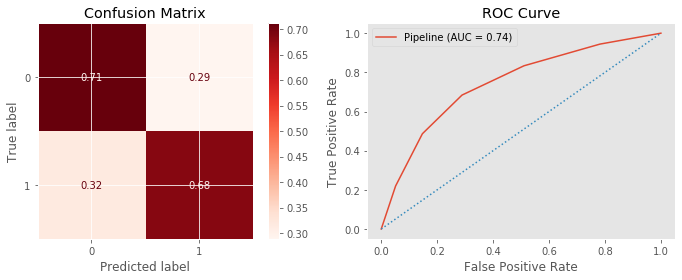

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT for SVM
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      6973
           1       0.76      0.66      0.71      6765

    accuracy                           0.73     13738
   macro avg       0.73      0.73      0.73     13738
weighted avg       0.73      0.73      0.73     13738

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.7385346145446604
Test data score: 0.7293638084146163
------------------------------------------------------------



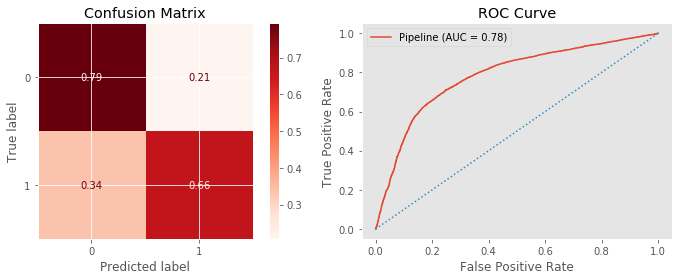

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT for TREE
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.65      0.64      6973
           1       0.63      0.61      0.62      6765

    accuracy                           0.63     13738
   macro avg       0.63      0.63      0.63     13738
weighted avg       0.63      0.63      0.63     13738

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.9763594671325617
Test data score: 0.6300043674479546
------------------------------------------------------------

Model may be Overfitting


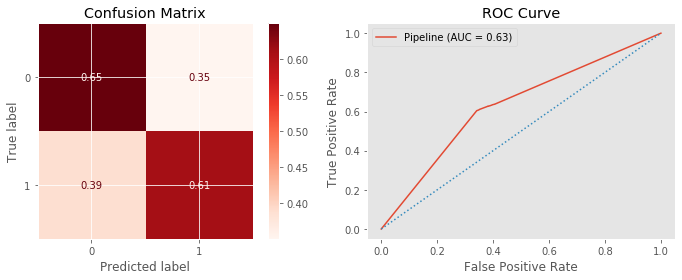

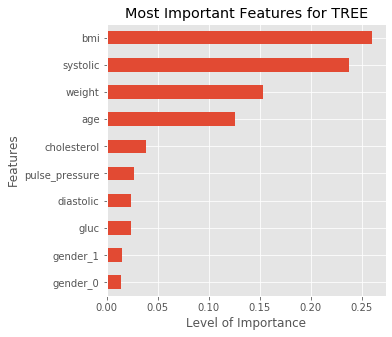

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT for RF
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      6973
           1       0.70      0.68      0.69      6765

    accuracy                           0.70     13738
   macro avg       0.70      0.70      0.70     13738
weighted avg       0.70      0.70      0.70     13738

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.9763412681080295
Test data score: 0.6977726015431649
------------------------------------------------------------

Model may be Overfitting


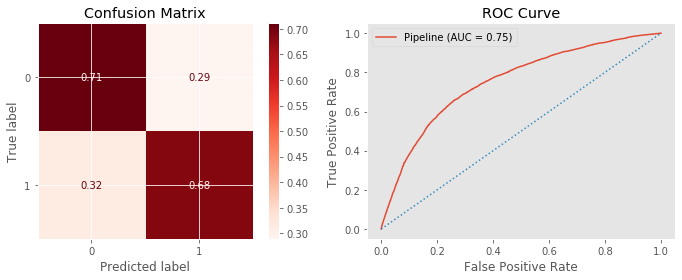

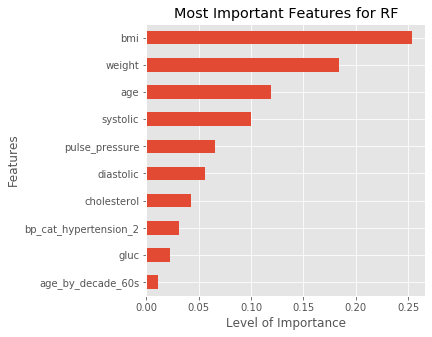

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT for XGB
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.78      0.75      6973
           1       0.75      0.68      0.71      6765

    accuracy                           0.73     13738
   macro avg       0.73      0.73      0.73     13738
weighted avg       0.73      0.73      0.73     13738

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.737679260391643
Test data score: 0.7308924151987188
------------------------------------------------------------



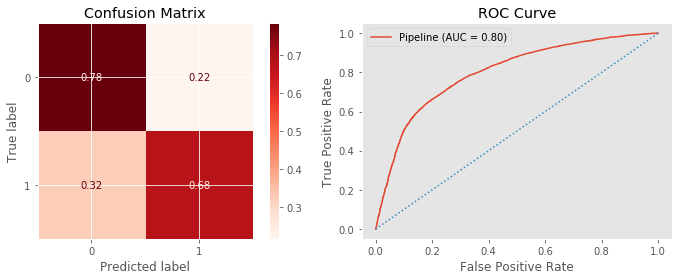

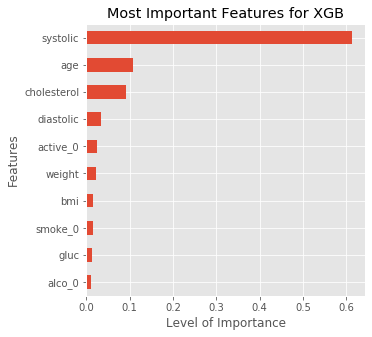

In [133]:
# Evaluating Vanilla models through our multi_pipe dictionary
for key, pipe in multi_pipes.items():
    pipe.fit(X_train, y_train)
    evaluate_classification(pipe, X_test, y_test,
                            X_train, y_train, label=key, preprocessed=1)

### Answer for Question 1:

Out of all of our vanilla models we've run through so far, it seems that XGBoost is performing the best in terms of accuracy, with our SVM model right behind, and our RandomForest model in third. Our Decision Tree, Random Forest, and KNN models are all overfitting. 

- XGBoostClassifier and SVClassifier are performing 45% better than our Baseline model's accuracy.

- RandomForestClassifier is performing 40% better compared to our baseline model's accuracy.

We will work on the following models to fine tune using RandomizedSearch and GridSearch:

- RandomForestClassifier
- SVClassifier
- XGBoostClassifier

**Recommendation**:

If I had to recommend one model from our top 3 performers, I would recommend XGBoostClassifier. Less feature engineering is required (it doesn't need scaling, can handle missing data), it is robust to outliers, has the best model performance, quick execution speed, and not as prone to overfit as some of the tree models. The downside to using this model is the time it takes to tune because of the amount of hyperparameters within the Classifier.

## Using RandomizedSearch & GridSearch to hone in on best parameters

Using our defined function model_search, we take advantage of gridsearch to hone in on the best parameters based on the score we are going after. It can be time consuming depending on the size of the dataset, along with the number of parameters within our defined param_grid. A strategy I've picked up has been to use randomizedSearch first, using a widespread array or parameters to find the best parameters. From there, I hone in within those parameters using GridSearch.

## Loading in Our Best Models

### Random Forest

This pickling function allows me to load and save the optimal models.

In [64]:
def pickling(name, model=None, task='save'):
    """
    Definition:
    Save or load a model using pickle
    
    Args:
    name: name you wish to save or load model
    model: model you want to save
    task: Specify the type of task you want the function to perform. Can be
          either 'save' or 'load'
          
    Returns: model, if task == 'load'
    """
    if task == 'save':
        pickled = name + '.pickle'
        with open(pickled, 'wb') as f:
            pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)
            
    if task == 'load':
        pickled = name + '.pickle'
        with open(pickled, 'rb') as f:
            loaded_model = pickle.load(f)
        return loaded_model

In [62]:
best_rf = pickling(name='best_rf', task='load')

In [66]:
with sklearn.config_context(display='diagram'):
    display(best_rf)

Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'weight', 'systolic',
                                                   'diastolic', 'bmi',
                                                   'pulse_pressure', 'gluc',
                                                   'cholesterol']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'smoke', 'alco',
                                                   'active', 'bp_cat',
                                                   'bmi_cat',
                                                   'age_by_decade'])])),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_depth=15,
                                        max_features=10, min_samples_leaf=5,
                                        min_samples_split=100, n_estimators=300,
                                        oob_score=True))])

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT for RF
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6973
           1       0.75      0.68      0.71      6765

    accuracy                           0.73     13738
   macro avg       0.73      0.73      0.73     13738
weighted avg       0.73      0.73      0.73     13738

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.7542403727160224
Test data score: 0.7321298587858495
------------------------------------------------------------



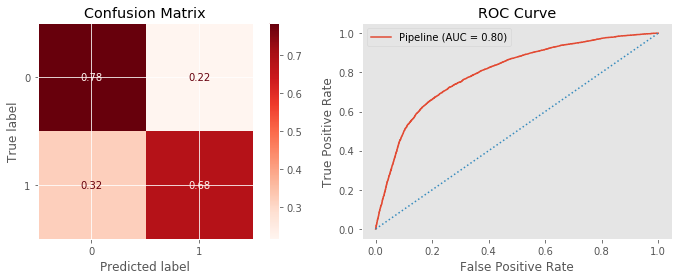

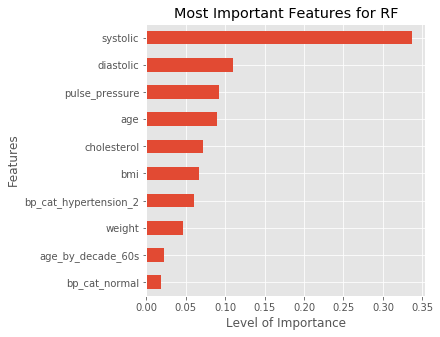

In [69]:
evaluate_classification(best_rf, X_test, y_test, X_train, y_train, 
                       preprocessed=1, label='rf')

We've managed to increase the accuracy of our RandomForestClassifier by about 3% from fine tuning useing gridsearch.

### SVC Model

In [71]:
best_svc = pickling(name='best_svc', task='load')

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT for SVM
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.83      0.75      6973
           1       0.78      0.61      0.68      6765

    accuracy                           0.72     13738
   macro avg       0.73      0.72      0.72     13738
weighted avg       0.73      0.72      0.72     13738

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.7241391861396229
Test data score: 0.7212840296986461
------------------------------------------------------------



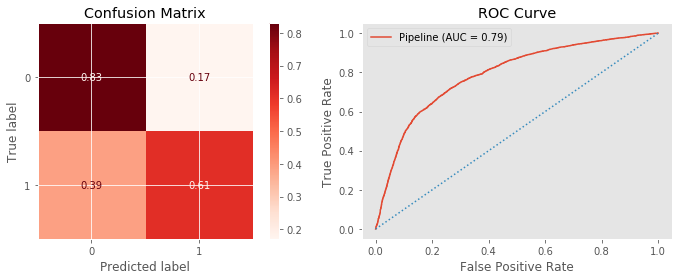

In [72]:
evaluate_classification(best_svc, X_test, y_test, X_train, y_train, 
                       preprocessed=1, label='svm')

### XGBoost

In [81]:
best_xgb = pickling(name='best_xgb', task='load')

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT for XGB
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      6973
           1       0.76      0.67      0.71      6765

    accuracy                           0.73     13738
   macro avg       0.74      0.73      0.73     13738
weighted avg       0.73      0.73      0.73     13738

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.7395719589430007
Test data score: 0.7321298587858495
------------------------------------------------------------



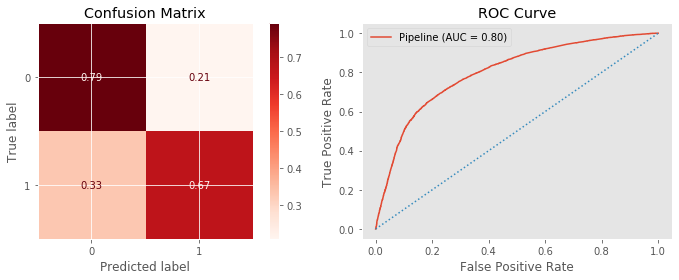

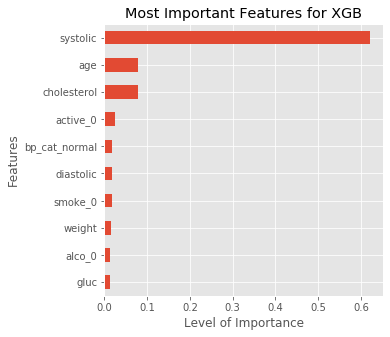

In [82]:
evaluate_classification(best_xgb, X_test, y_test, X_train, y_train, 
                       preprocessed=1, label='xgb')                                                                

### Answer for Question 2:

For our best XGBClassifier Model, the most significant factors that best predict if an observation is with or without a CVD are:

- Systolic pressure
- Age
- Cholesterol
- Sedentary Lifestyle (active_0)

While we know that these are significant factors, we do not know if they are risk or protective factors. For example, we know that systolic pressure is extremely significant, but is lower or higher systolic pressure the risk factor? or both? 

**Recommendation**:

If we want to figure out the greatest positive and negative feature importances of our model, we can use a library called Shap. Shap allows us to not only plot the most significant factors, but also the positive and/or negative correlation those features have with our target variable (in this case, CVD). With this information, we are able to interpret risk and protective factors for CVDs within our dataset.

## Stacking Classifier (Still Testing This Out)

The StackingClassifier allows us to combine our strongest models into one stacked model. Each of our models uses its strength within the StackingClassifier and get combined to produce a final estimator with the strengths of all our estimator models.

In [136]:
from sklearn.ensemble import StackingClassifier

In [137]:
estimators = [
    ('rf', best_rf), 
    ('xgb', best_xgb),
    ('svm', best_svc)
]

In [138]:
stack_clf = StackingClassifier(estimators=estimators)

In [139]:
with sklearn.config_context(display='diagram'):
    display(stack_clf.fit(X_train, y_train))

StackingClassifier(estimators=[('rf',
                                Pipeline(steps=[('preprocesser',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(strategy='median'))]),
                                                                                  ['age',
                                                                                   'weight',
                                                                                   'systolic',
                                                                                   'diastolic',
                                                                                   'bmi',
                                                                                   'pulse_pressure',
                                                                                   'gluc',
                                                                                   'cholesterol']),
                                                                                 ('cat',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value='missing',
                                                                                                                 strategy='constant')),
                                                                                                  ('e...
                                                                                                   StandardScaler())]),
                                                                                  ['age',
                                                                                   'weight',
                                                                                   'systolic',
                                                                                   'diastolic',
                                                                                   'bmi',
                                                                                   'pulse_pressure',
                                                                                   'gluc',
                                                                                   'cholesterol']),
                                                                                 ('cat',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value='missing',
                                                                                                                 strategy='constant')),
                                                                                                  ('encoder',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse=False))]),
                                                                                  ['gender',
                                                                                   'smoke',
                                                                                   'alco',
                                                                                   'active',
                                                                                   'bp_cat',
                                            

In [97]:
# stack_clf.named_estimators['rf'].named_steps['preprocesser'].named_transformers_['cat'].\
#                             named_steps['encoder'].get_feature_names(cat_cols).tolist()

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6973
           1       0.75      0.68      0.72      6765

    accuracy                           0.73     13738
   macro avg       0.73      0.73      0.73     13738
weighted avg       0.73      0.73      0.73     13738

------------------------------------------------------------
------------------------------------------------------------
Training data score: 0.742975176530538
Test data score: 0.7332217207744941
------------------------------------------------------------



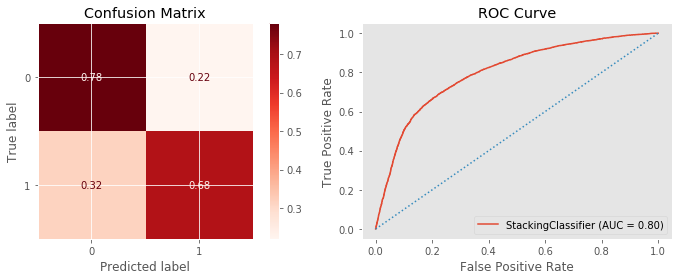

In [141]:
evaluate_classification(stack_clf, X_test, y_test, X_train, y_train)

Our StackingClassifier has acheieved the highest accuracy score so far out of all the models we've run, with a 73.3% -- 0.1% better than our XGBoostClassifier model.

## Using SHAP

#### Using Our Best XGBClassifier Model

In [93]:
best_xgb.named_steps['xgb'].get_params

<bound method XGBModel.get_params of XGBClassifier(gamma=5, max_depth=5, min_child_weight=3, missing=nan)>

In [94]:
xgb_clf = xgb.XGBClassifier(gamma=5, max_depth=5, min_child_weight=3, missing=None)

In [95]:
def shap_summary(model, X_train, y_train, X_test, num_cols, cat_cols, scale=0):
    """
    Definition:
    using Shap, plots a summary plot of the model's feature importances to display
    the level of importance, along with whether or not the feature has a 
    positive or negative correlation with the target.
    
    Args:
    model: desired classification model to be used
    X_train, y_train, X_test: Self-explanatory
    num_cols: numerical columns in dataframe
    cat_cols: categorical columns in dataframe (not including target)
    scale: default=0. Whether or not the model requires the data to be scaled
    
    Plots:
    A summary plot showing the model's most important features within the data 
    """
    shap.initjs()
    
    # For models that require their numerical features to be scaled
    if scale:
        preprocess = preprocess_1
        X_train_tf = preprocess.fit_transform(X_train)
        X_test_tf = preprocess.transform(X_test)

    # For models that don't require numerical features to be scaled
    else:
        preprocess = preprocess_2
        X_train_tf = preprocess.fit_transform(X_train)
        X_test_tf = preprocess.transform(X_test)
    
    cat_feat_names = preprocess.named_transformers_['cat'].\
                 named_steps['encoder'].get_feature_names(cat_cols).tolist()
    feature_cols = num_cols + cat_feat_names
    X_train_df = pd.DataFrame(X_train_tf, columns=feature_cols)
    
    model.fit(X_train_df, y_train)
    explainer = shap.TreeExplainer(model=model)
    shap_values = explainer.shap_values(X_train_df, y_train)
    shap.summary_plot(shap_values, X_train_df)

In [ ]:
num_cols = ['age', 'weight', 'systolic', 'diastolic', 'bmi', 'pulse_pressure', 
            'gluc', 'cholesterol'] 
cat_cols = ['gender', 'smoke', 'alco', 'active', 'bp_cat', 'bmi_cat', 
            'age_by_decade']

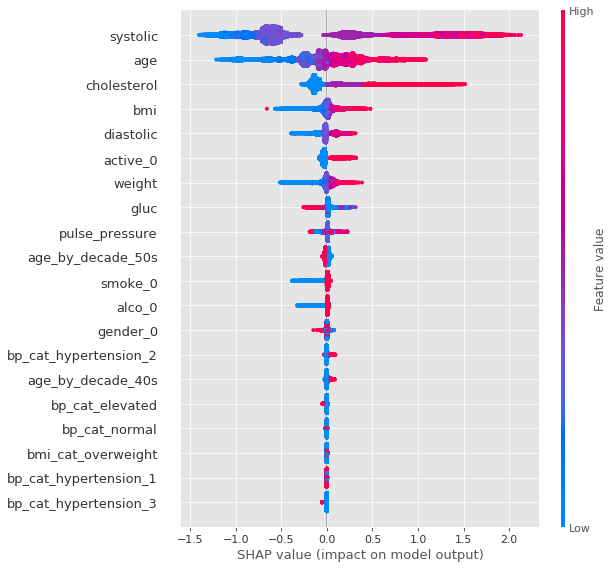

In [96]:
shap_summary(xgb_clf, X_train, y_train, X_test, num_cols, cat_cols)

# Interpretation

### Answer for Question 3:

According to our shap.summary_plot, we can see that Systolic pressure seems to be the most significant factor (both risk and protective) when it comes to determining if an observation has a CVD. 

**Top 5 Most Significant Factors:**
- Systolic Pressure / Diastolic Pressure (BP)
- Age
- Cholesterol
- BMI
- Sedentary Lifestyle (Active_0)

**Top 5 Risk Factors:**
- High Systolic Pressure / High Diastolic Pressure (High BP)
- Elderly person (high in age)
- Higher Cholesterol Level
- A high BMI
- Sedentary lifestyle


**Top 5 Protective Factors:**
- Low Systolic Pressure / Low Diastolic Pressure (Lower BP)
- Younger in age
- Low cholesterol level
- Lower BMI
- Active Lifestyle

**Recommendations**:

Staying active, eating healthy, maintaining a lower BMI all play a significant part in reducing the risk of developing/having a CVD. Awareness of the importance of these factors is key to keeping your risk as low as possible. Targeting retirement communities and educating them about prevalence, protection, and how to best lower their risk for any CVDs may help lower the number of deaths from CVDs. Informing and continuously teaching youth throughout grades about CVDs and the protective and risk factors may also help lower the casualty rate over time.

**Conclusion:**

While we cannot turn back the clock on age, we can still control some of these important factors. Adopting and maintaining a physically active (any level of activity) lifestyle helps reduce the risk of getting a CVD. Being active can also help reduce a higher BMI and help shed pounds. High cholesterol levels can be controlled by eating healthier (along with correct portion sizes) and staying active; in more serious cases, it can be monitored and controlled through medication. Staying active and eating healthier will in turn also lower blood pressure. Gaining basic health knowledge on these fundamental protective factors could help drop Cardiovascular Disease from the number one spot on Top Causes of Death.


# Citations

1. "*All About Adult BMI"* Centers for Disease Control and Prevention. https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html. Accessed October 4th, 2020.

2. Yildiran, Tansel et al. *“Low pulse pressure as a predictor of death in patients with mild to advanced heart failure.”* Texas Heart Institute journal vol. 37,3 (2010): 284-90.

3. *“Understanding Blood Pressure Readings.”* American Heart Association, www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings. Accessed October 4th, 2020.

4. Narloch, J A, and M E Brandstater. *“Influence of breathing technique on arterial blood pressure during heavy weight lifting.”* Archives of physical medicine and rehabilitation vol. 76,5 (1995): 457-62.

5. Dr G. M. C. Rosano, C. Vitale, G. Marazzi & M. Volterrani (2007) *Menopause and cardiovascular disease: the evidence*, Climacteric, 10:sup1, 19-24, DOI: 10.1080/13697130601114917

6. *“Excess Growth Hormone Increases Risk of Heart Disease, Diabetes.”* NIH Record, nihrecord.nih.gov/2018/01/26/excess-growth-hormone-increases-risk-heart-disease-diabetes#:%7E:text=Excess%20Growth%20Hormone%20Increases%20Risk%20of%20Heart%20Disease%2C%20Diabetes,-By%20Eric%20Bock&text=Diseases%20of%20excess%20growth%20hormone,Rounds%20lecture%20in%20Lipsett%20Amphitheater. 
Accessed 11 Sept. 2020.

7. Burger, Albert G et al. *“Cardiovascular risk in patients with growth hormone deficiency: effects of growth hormone substitution.”* Endocrine practice : official journal of the American College of Endocrinology and the American Association of Clinical Endocrinologists vol. 12,6 (2006): 682-9.